In [ ]:
!pip install kaggle

In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
sns.set_palette("Set2")

print("⬇️ Download del dataset in corso...")
path = kagglehub.dataset_download("atharvasoundankar/spotify-global-streaming-data-2024")
print("✅ Path dataset:", path)

csv_file = None
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_file = file
        print(f"📄 Trovato file: {file}")
        break

if csv_file is None:
    raise FileNotFoundError("Non ho trovato nessun file CSV nel dataset scaricato!")

df = pd.read_csv(os.path.join(path, csv_file))
print("\nDimensioni del dataset:", df.shape)
print("\nPrime righe del dataset:")
display(df.head())

print("\n🔍 Nomi delle colonne disponibili:", df.columns.tolist())

⬇️ Download del dataset in corso...


100%|██████████| 27.4k/27.4k [00:00<00:00, 34.2MB/s]

Extracting files...
✅ Path dataset: /root/.cache/kagglehub/datasets/atharvasoundankar/spotify-global-streaming-data-2024/versions/2
📄 Trovato file: Cleaned_Spotify_2024_Global_Streaming_Data.csv

Dimensioni del dataset: (500, 12)

Prime righe del dataset:


,Country,Artist,Album,Genre,Release Year,Monthly Listeners (Millions),Total Streams (Millions),Total Hours Streamed (Millions),Avg Stream Duration (Min),Platform Type,Streams Last 30 Days (Millions),Skip Rate (%)
0,Germany,Taylor Swift,1989 (Taylor's Version),K-pop,2020,23.10,3695.53,14240.35,4.28,Free,118.51,2.24
1,Brazil,The Weeknd,After Hours,R&B,2023,60.60,2828.16,11120.44,3.90,Premium,44.87,23.98
2,United States,Post Malone,Austin,Reggaeton,2019,42.84,1425.46,4177.49,4.03,Free,19.46,4.77
3,Italy,Ed Sheeran,Autumn Variations,K-pop,2019,73.24,2704.33,12024.08,3.26,Premium,166.05,25.12
4,Italy,Ed Sheeran,Autumn Variations,R&B,2019,7.89,3323.25,13446.32,4.47,Free,173.43,15.82



🔍 Nomi delle colonne disponibili: ['Country', 'Artist', 'Album', 'Genre', 'Release Year', 'Monthly Listeners (Millions)', 'Total Streams (Millions)', 'Total Hours Streamed (Millions)', 'Avg Stream Duration (Min)', 'Platform Type', 'Streams Last 30 Days (Millions)', 'Skip Rate (%)']


In [ ]:

n_samples = min(1000, len(df))
df_sample = df.sample(n=n_samples, random_state=0)
print(f"\nUso un campione di {n_samples} tracce.")

categorical_features = ['Genre']

numeric_features = [
    'Monthly Listeners (Millions)',
    'Total Streams (Millions)',
    'Total Hours Streamed (Millions)',
    'Avg Stream Duration (Min)'
]

features_to_use = categorical_features + numeric_features
X = df_sample[features_to_use].dropna()
X['Genre_orig'] = X['Genre']
X_cat = pd.get_dummies(X[categorical_features], prefix=categorical_features)
scaler = StandardScaler()

X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X[numeric_features]),
    columns=numeric_features,
    index=X.index
)

X_final = pd.concat([X_num_scaled, X_cat], axis=1)
X_viz = pd.concat([X[numeric_features], X['Genre_orig']], axis=1)

print("\n✅ Dataset pronto per il clustering!")
print("Shape finale:", X_final.shape)
print("Prime colonne:", X_final.columns[:5].tolist())


Uso un campione di 500 tracce.

✅ Dataset pronto per il clustering!
Shape finale: (500, 14)
Prime colonne: ['Monthly Listeners (Millions)', 'Total Streams (Millions)', 'Total Hours Streamed (Millions)', 'Avg Stream Duration (Min)', 'Genre_Classical']



📊 Distribuzione dei dati prima del clustering:



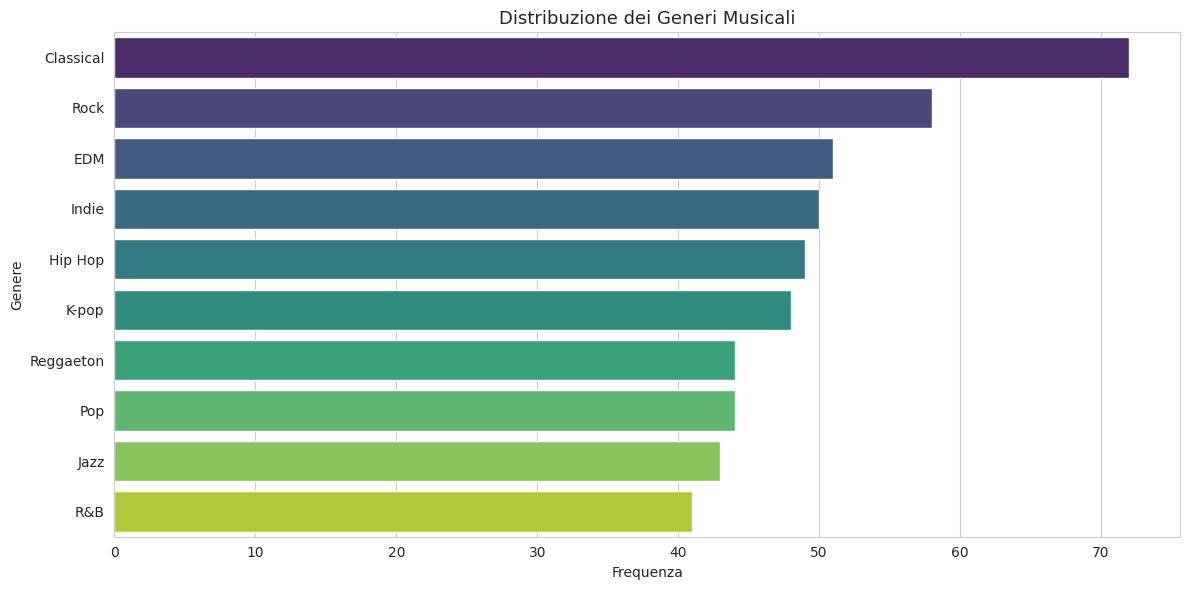

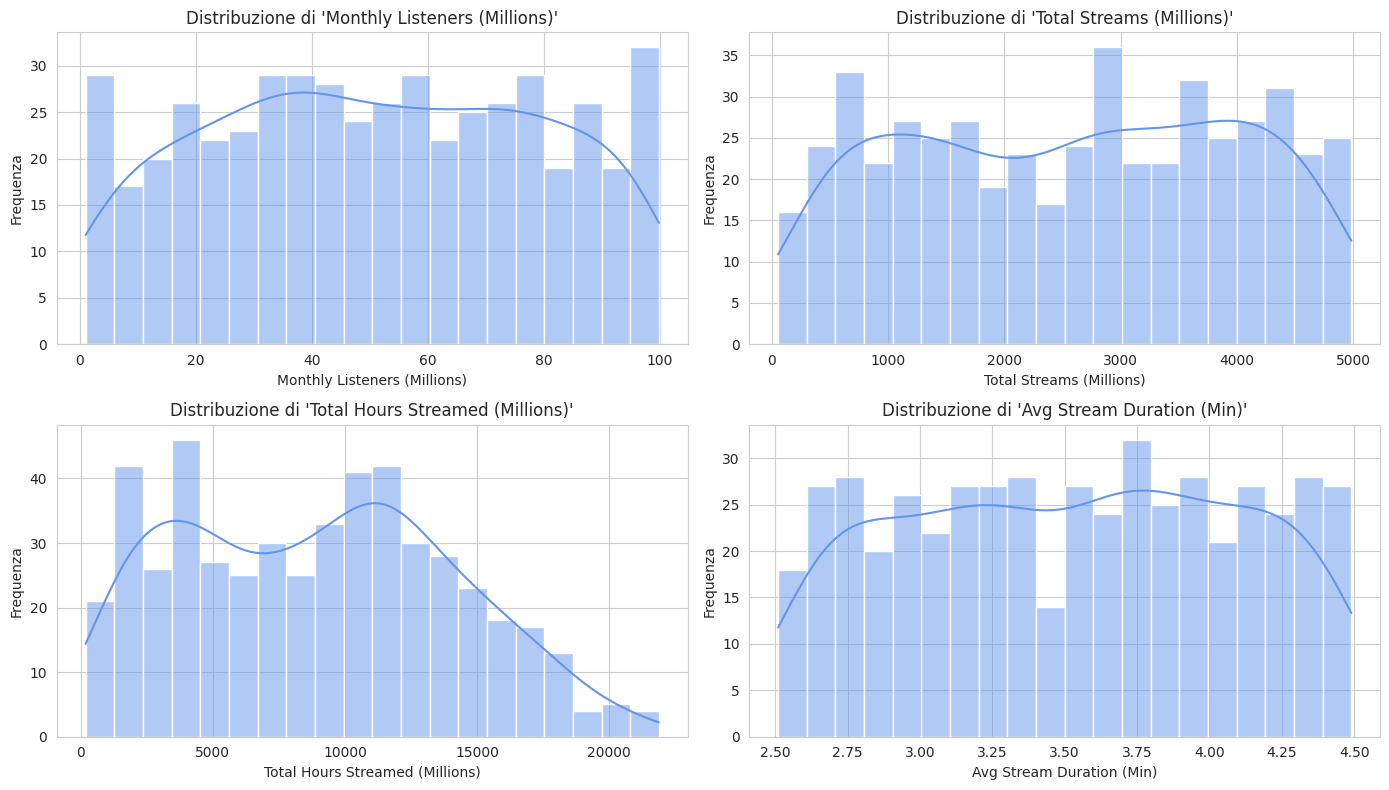

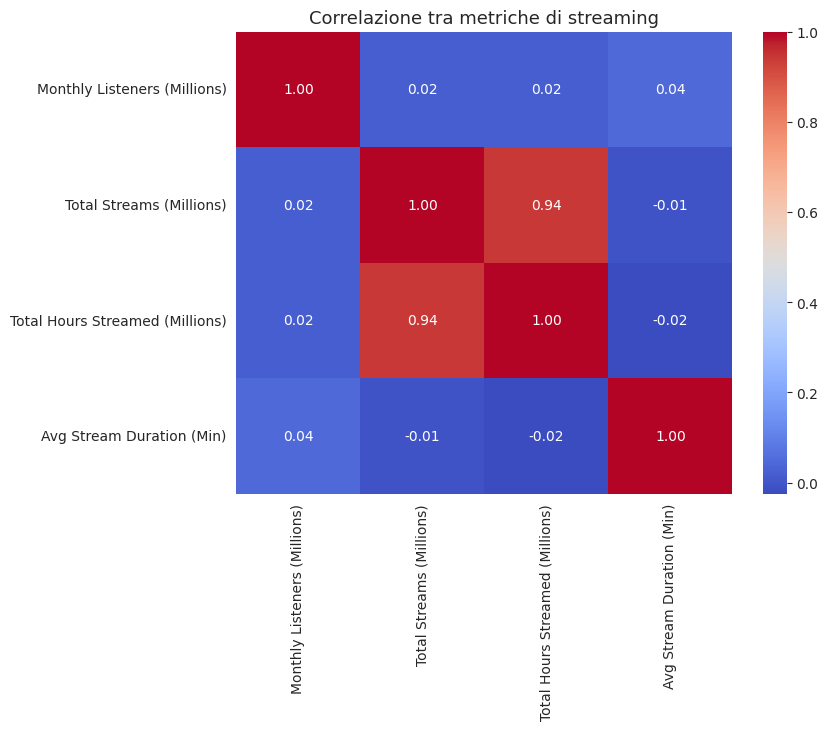

In [ ]:

print("\n📊 Distribuzione dei dati prima del clustering:\n")

counts = X_viz["Genre_orig"].value_counts().reset_index()
counts.columns = ["Genre", "count"]

plt.figure(figsize=(12, 6))
sns.barplot(
    y="Genre",
    x="count",
    data=counts,
    palette="viridis",
    hue="Genre",
    legend=False
)
plt.title("Distribuzione dei Generi Musicali", fontsize=13)
plt.xlabel("Frequenza")
plt.ylabel("Genere")
plt.tight_layout()
plt.show()

n_cols = 2
n_rows = int(np.ceil(len(numeric_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(
        X_viz[col],
        kde=True,
        bins=20,
        color="cornflowerblue",
        ax=axes[i]
    )
    axes[i].set_title(f"Distribuzione di '{col}'", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequenza")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
corr = X_viz[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlazione tra metriche di streaming", fontsize=13)
plt.show()

⏳ Calcolo delle metriche per i diversi k...


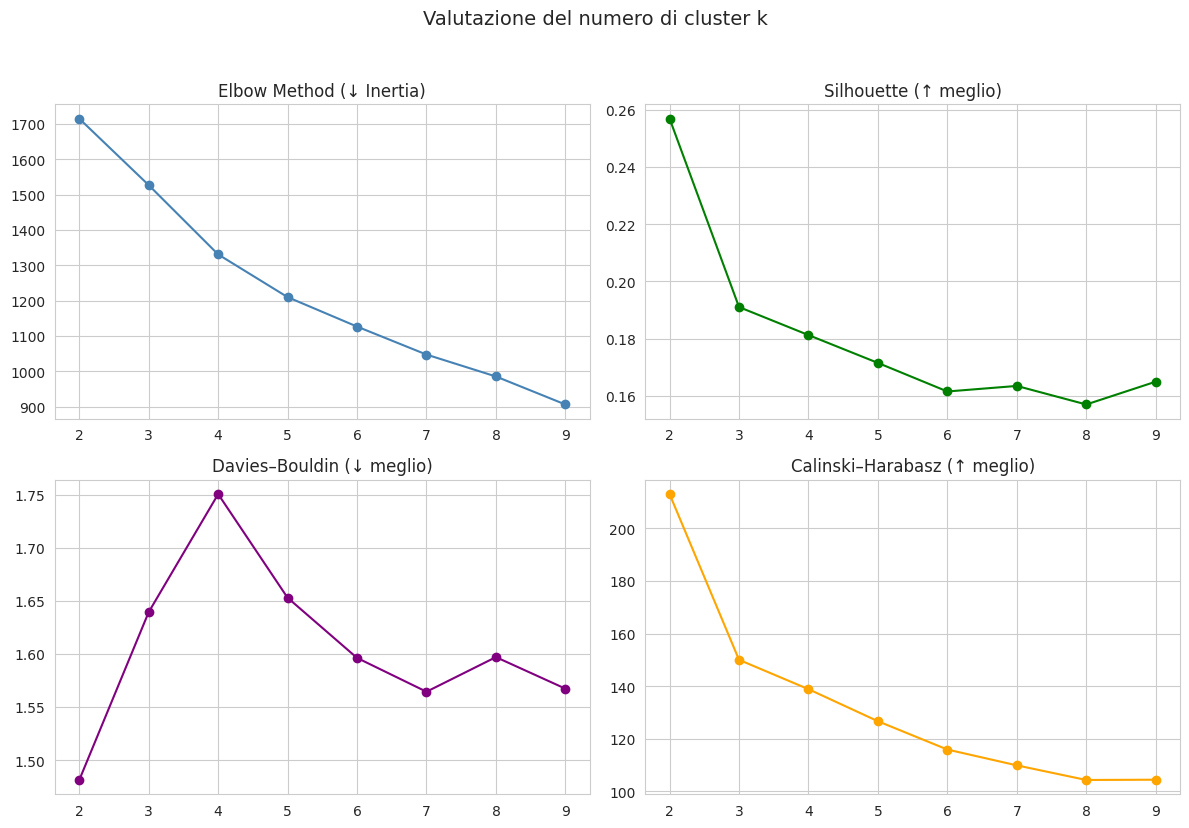


⭐ Miglior k secondo ogni metrica:
  - Silhouette:           2
  - Davies–Bouldin:       2
  - Calinski–Harabasz:    2
  - Elbow (Differences):  4
  - Elbow (Distance):     5

👉 K finale scelto automaticamente: 2


In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math

X_scaled = X_final.values
K = range(2, 10)
inertias = []
silhouette_scores = []
db_scores = []
ch_scores = []

print("⏳ Calcolo delle metriche per i diversi k...")

for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(X_scaled)

    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0,0].plot(K, inertias, 'o-', color='steelblue')
axs[0,0].set_title("Elbow Method (↓ Inertia)")
axs[0,0].grid(True)

axs[0,1].plot(K, silhouette_scores, 'o-', color='green')
axs[0,1].set_title("Silhouette (↑ meglio)")
axs[0,1].grid(True)

axs[1,0].plot(K, db_scores, 'o-', color='purple')
axs[1,0].set_title("Davies–Bouldin (↓ meglio)")
axs[1,0].grid(True)

axs[1,1].plot(K, ch_scores, 'o-', color='orange')
axs[1,1].set_title("Calinski–Harabasz (↑ meglio)")
axs[1,1].grid(True)

plt.suptitle("Valutazione del numero di cluster k", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

def elbow_diff_method(k_vals, inertias):
    diff_inertias = np.diff(inertias)
    ratios = np.abs(diff_inertias[1:] / diff_inertias[:-1])
    best_k = k_vals[np.argmin(np.abs(ratios - 1)) + 2]
    return best_k

def detect_elbow_distance(k_vals, inertias):
    p1x, p1y = k_vals[0], inertias[0]
    p2x, p2y = k_vals[-1], inertias[-1]
    dists = []
    for k, val in zip(k_vals, inertias):
        px, py = k, val
        num = abs((p2x - p1x) * (p1y - py) - (p2y - p1y) * (p1x - px))
        den = math.hypot(p2x - p1x, p2y - p1y)
        dists.append(num / den if den != 0 else 0.0)
    elbow_idx = int(np.argmax(dists))
    return int(k_vals[elbow_idx]), dists

best_k_sil = K[np.argmax(silhouette_scores)]
best_k_db = K[np.argmin(db_scores)]
best_k_ch = K[np.argmax(ch_scores)]
best_k_el_diff = elbow_diff_method(K, inertias)
best_k_el_dist, _ = detect_elbow_distance(K, inertias)

print("\n⭐ Miglior k secondo ogni metrica:")
print(f"  - Silhouette:           {best_k_sil}")
print(f"  - Davies–Bouldin:       {best_k_db}")
print(f"  - Calinski–Harabasz:    {best_k_ch}")
print(f"  - Elbow (Differences):  {best_k_el_diff}")
print(f"  - Elbow (Distance):     {best_k_el_dist}")

best_overall = Counter([
    best_k_sil, best_k_db, best_k_ch, best_k_el_diff, best_k_el_dist
]).most_common(1)[0][0]

print(f"\n👉 K finale scelto automaticamente: {best_overall}")

X = X_viz.copy()
km = KMeans(n_clusters=best_overall, random_state=0)
X['cluster'] = km.fit_predict(X_scaled)

In [ ]:
import statsmodels.stats.multitest as smm
from scipy import stats

def interpret_pval(p):
    if p < 0.001: return "highly significant"
    elif p < 0.01: return "significant"
    elif p < 0.05: return "weakly significant"
    else: return "not significant"

def analyze_k(k_val):
    print(f"\n{'='*60}\n🔹 ANALISI PER k = {k_val}\n{'='*60}")

    labels = KMeans(n_clusters=k_val, random_state=0).fit_predict(X_scaled)
    X[f'cluster_{k_val}'] = labels

    print(f"✅ KMeans fatto per k = {k_val}")

    pvals = {}
    for col in numeric_features:
        groups = [X.loc[X[f'cluster_{k_val}']==c, col] for c in range(k_val)]

        if any(len(g) < 2 for g in groups):
            continue

        try:
            stat, p = stats.kruskal(*groups)
            pvals[col] = p
        except ValueError:
            continue

    if pvals:
        _, pvals_fdr, _, _ = smm.multipletests(list(pvals.values()), method='fdr_bh')
        pvals_corr = dict(zip(pvals.keys(), pvals_fdr))

        print("\n📈 SIGNIFICATIVITÀ (Kruskal-Wallis con FDR) per features numeriche:")
        display(pd.DataFrame.from_dict(pvals_corr, orient='index', columns=['p-value_FDR']).round(4))
    else:
        print("⚠️ Nessuna feature numerica adatta al test.")

    if 'Genre_orig' in X.columns:
        contingency = pd.crosstab(X['Genre_orig'], X[f'cluster_{k_val}'])
        contingency = contingency.loc[(contingency.sum(axis=1) > 5)]

        if not contingency.empty:
            chi2, p, _, _ = stats.chi2_contingency(contingency, correction=False)
            print(f"\n📊 Test Chi-quadro per 'Genre': p = {p:.4f}")
            print(f"- Genre: {interpret_pval(p)}")
        else:
            print("\n⚠️ Dati insufficienti per Chi-quadro su Genre (frequenze troppo basse).")
analyze_k(2)
analyze_k(4)


🔹 ANALISI PER k = 2
✅ KMeans fatto per k = 2

📈 SIGNIFICATIVITÀ (Kruskal-Wallis con FDR) per features numeriche:


,p-value_FDR
Monthly Listeners (Millions),0.6217
Total Streams (Millions),0.0000
Total Hours Streamed (Millions),0.0000
Avg Stream Duration (Min),0.6217



📊 Test Chi-quadro per 'Genre': p = 0.5634
- Genre: not significant

🔹 ANALISI PER k = 4
✅ KMeans fatto per k = 4

📈 SIGNIFICATIVITÀ (Kruskal-Wallis con FDR) per features numeriche:


,p-value_FDR
Monthly Listeners (Millions),0.0
Total Streams (Millions),0.0
Total Hours Streamed (Millions),0.0
Avg Stream Duration (Min),0.0



📊 Test Chi-quadro per 'Genre': p = 0.5771
- Genre: not significant



 RANDOM FOREST - k = 2

 Top 10 Features Importanti:


,0
Total Streams (Millions),0.2544
Total Hours Streamed (Millions),0.1936
Monthly Listeners (Millions),0.0000
Avg Stream Duration (Min),0.0000
Genre_Classical,0.0000
Genre_EDM,0.0000
Genre_Hip Hop,0.0000
Genre_Indie,0.0000
Genre_Jazz,0.0000
Genre_K-pop,0.0000



 RANDOM FOREST - k = 4

 Top 10 Features Importanti:


,0
Monthly Listeners (Millions),0.3912
Total Streams (Millions),0.2500
Avg Stream Duration (Min),0.2012
Total Hours Streamed (Millions),0.1440
Genre_EDM,0.0020
Genre_Classical,0.0000
Genre_Hip Hop,0.0000
Genre_Indie,0.0000
Genre_Jazz,0.0000
Genre_K-pop,0.0000


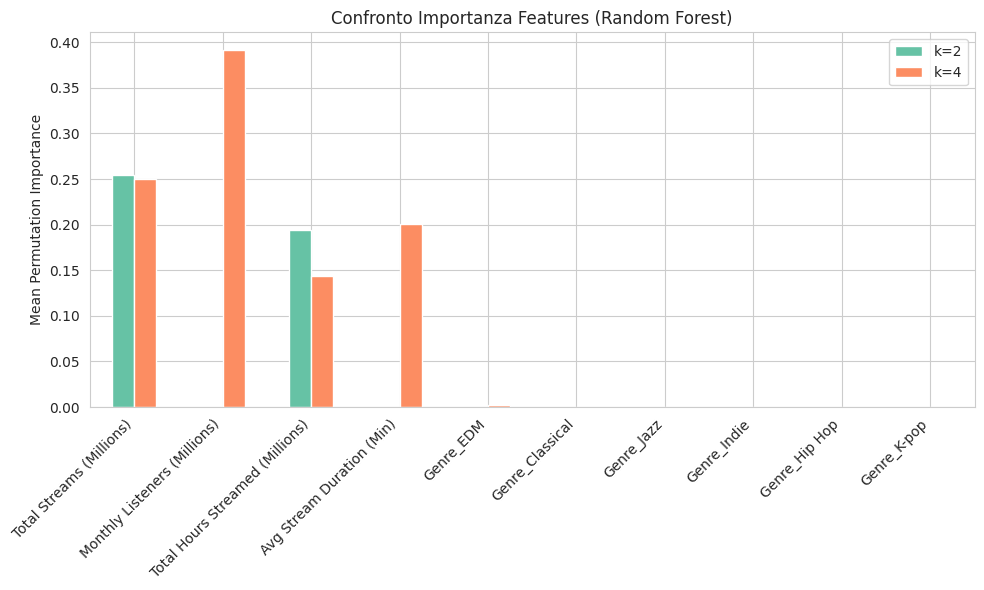

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

def rf_importance_for_k(k_val):
    print(f"\n{'='*60}\n RANDOM FOREST - k = {k_val}\n{'='*60}")

    km = KMeans(n_clusters=k_val, random_state=0)
    y = km.fit_predict(X_scaled)
    feature_names = X_final.columns.tolist()
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    rf.fit(X_final, y)

    perm = permutation_importance(rf, X_final, y, n_repeats=5, random_state=0)
    importances = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

    print("\n Top 10 Features Importanti:")
    display(importances.head(10))

    return importances

importances_k2 = rf_importance_for_k(2)
importances_k4 = rf_importance_for_k(4)
imp_compare = pd.DataFrame({
    'k=2': importances_k2,
    'k=4': importances_k4
}).fillna(0)

top_feats = imp_compare.sum(axis=1).sort_values(ascending=False).head(10).index
imp_top = imp_compare.loc[top_feats]

imp_top.plot(kind='bar', figsize=(10,6))
plt.title("Confronto Importanza Features (Random Forest)")
plt.ylabel("Mean Permutation Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


📊 Scatter plots per k = 2
Features assi: ['Total Streams (Millions)', 'Total Hours Streamed (Millions)']


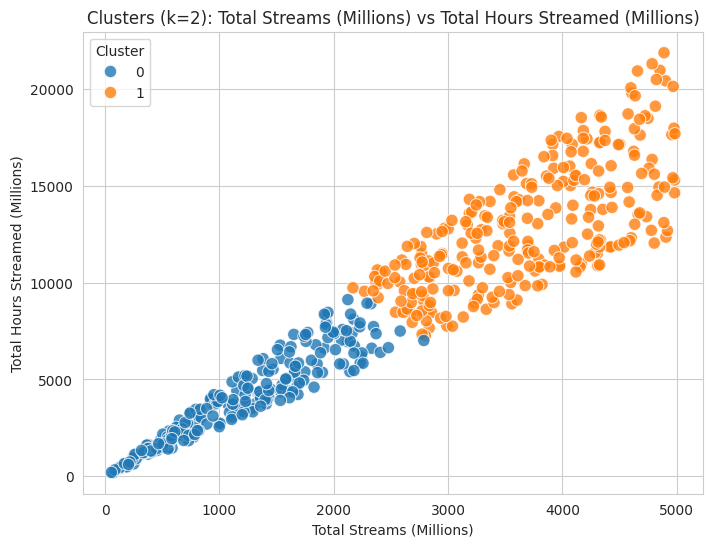


📊 Scatter plots per k = 4
Features assi: ['Monthly Listeners (Millions)', 'Total Streams (Millions)']


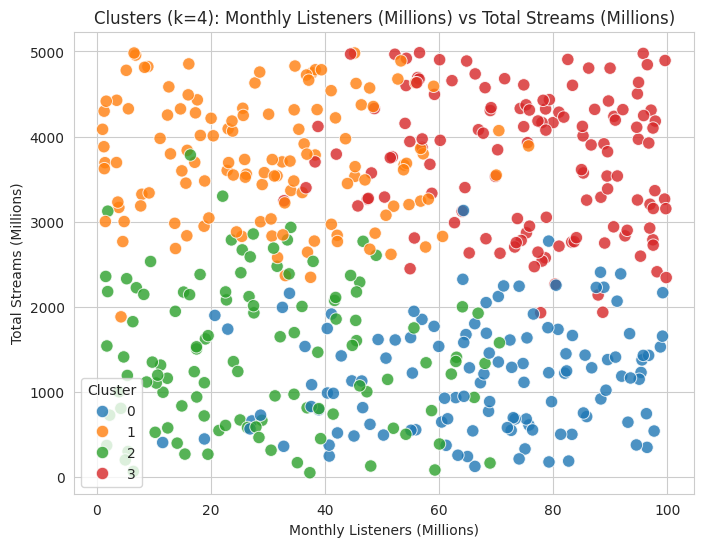


📊 VISUALIZZAZIONI DETTAGLIATE PER k = 2


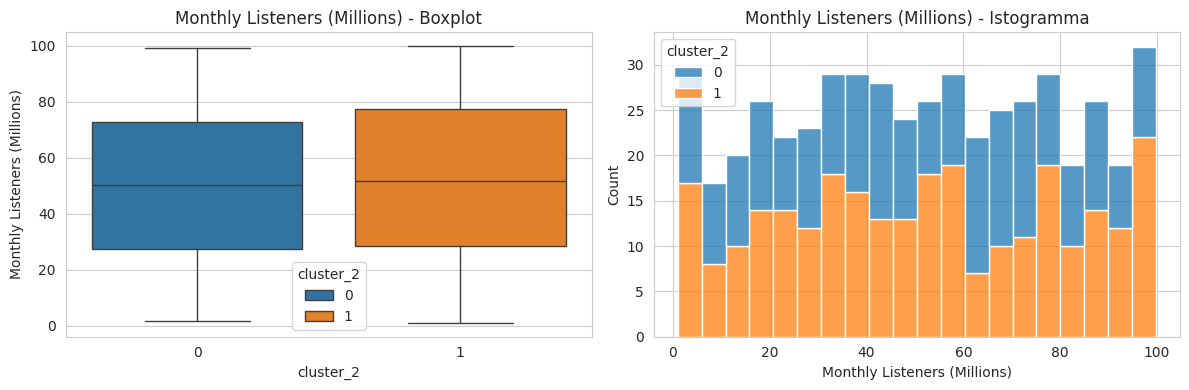

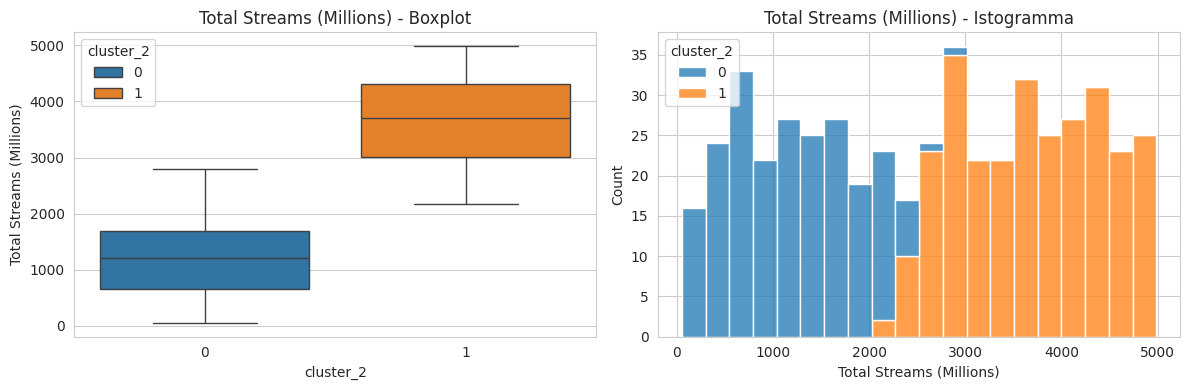

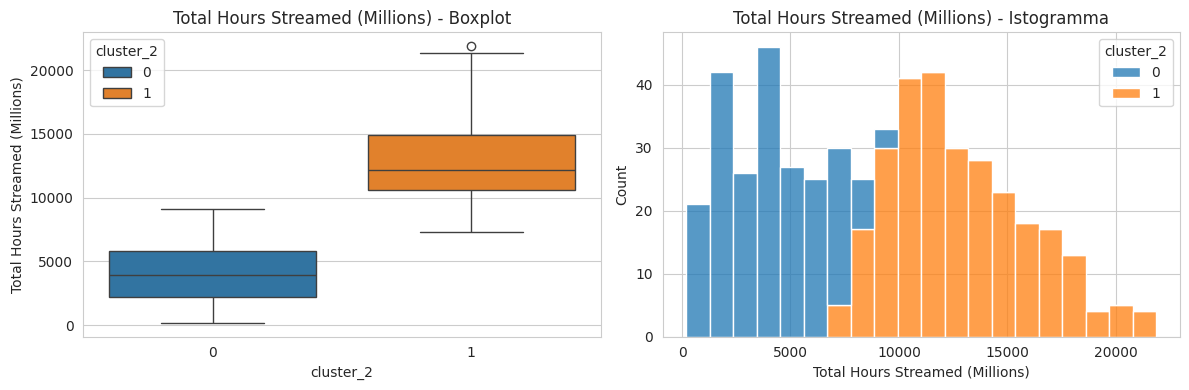

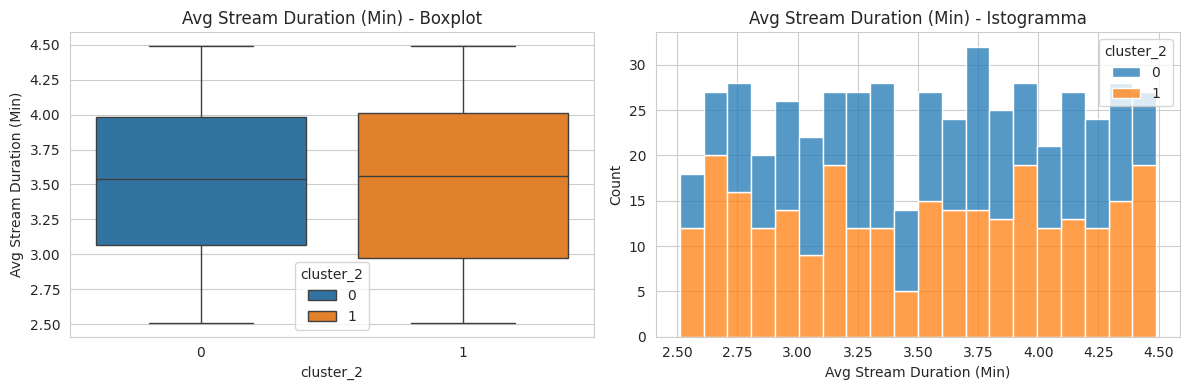


📊 VISUALIZZAZIONI DETTAGLIATE PER k = 4


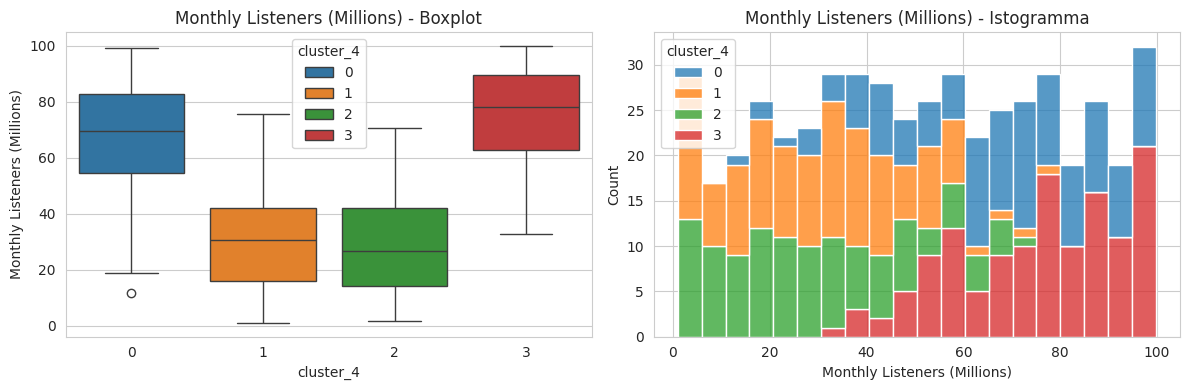

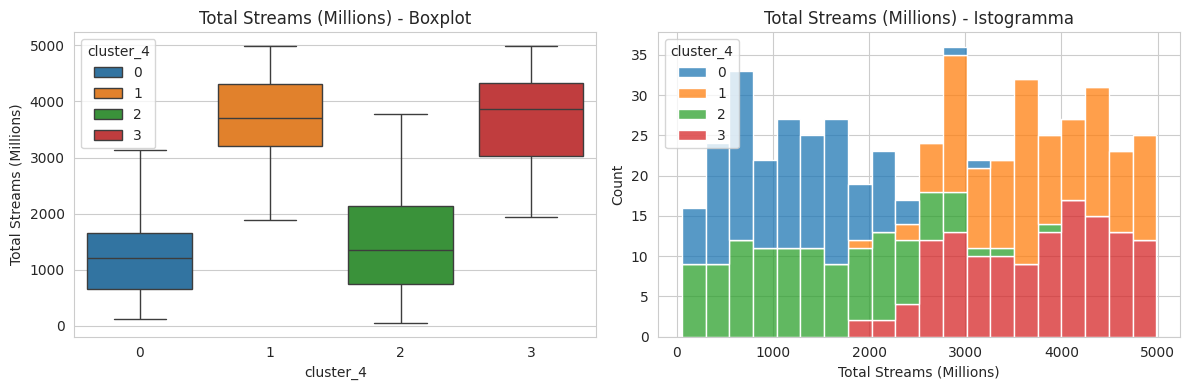

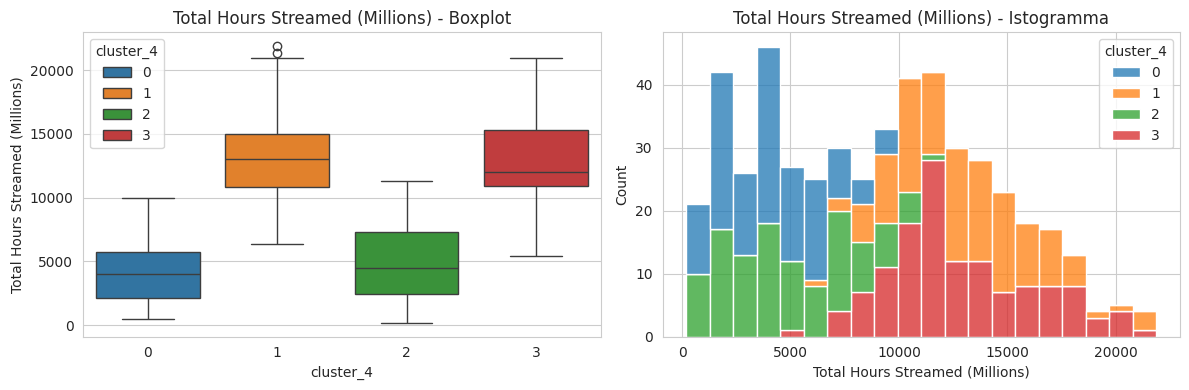

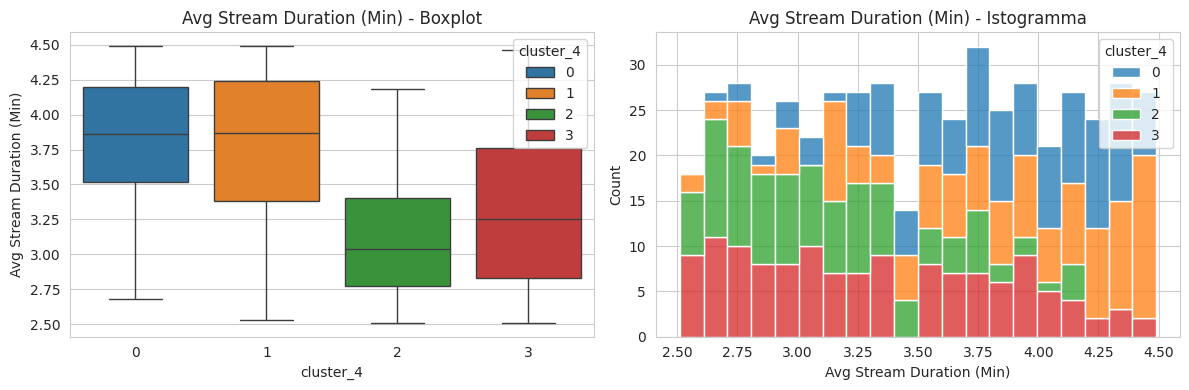

In [ ]:
def plot_clusters_numeric(k_val, importances, X_data):
    print(f"\n📊 Scatter plots per k = {k_val}")
    numeric_feats_sorted = [f for f in importances.index if f in numeric_features]

    if len(numeric_feats_sorted) < 2:
        print("Non ci sono abbastanza features numeriche dominanti per lo scatter plot.")
        return

    top_2 = numeric_feats_sorted[:2]
    print(f"Features assi: {top_2}")

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_data[top_2[0]],
        y=X_data[top_2[1]],
        hue=X_data[f'cluster_{k_val}'],
        palette='tab10',
        s=80, alpha=0.8
    )
    plt.title(f"Clusters (k={k_val}): {top_2[0]} vs {top_2[1]}")
    plt.xlabel(top_2[0])
    plt.ylabel(top_2[1])
    plt.legend(title='Cluster')
    plt.show()

plot_clusters_numeric(2, importances_k2, X)
plot_clusters_numeric(4, importances_k4, X)

def plot_visualizations_for_k(k_val, X_data):
    print(f"\n{'='*60}\n📊 VISUALIZZAZIONI DETTAGLIATE PER k = {k_val}\n{'='*60}")
    for col in numeric_features:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        sns.boxplot(
            x=f'cluster_{k_val}', y=col,
            hue=f'cluster_{k_val}', data=X_data,
            ax=axes[0], palette='tab10', dodge=False
        )
        axes[0].set_title(f"{col} - Boxplot")

        sns.histplot(
            data=X_data, x=col,
            hue=f'cluster_{k_val}', multiple='stack',
            bins=20, ax=axes[1], palette='tab10'
        )
        axes[1].set_title(f"{col} - Istogramma")

        plt.tight_layout()
        plt.show()

plot_visualizations_for_k(2, X)
plot_visualizations_for_k(4, X)

In [ ]:
import plotly.graph_objects as go

if 'cluster_2' in X.columns and 'cluster_4' in X.columns:
    sankey_data = X.groupby(['cluster_2', 'cluster_4']).size().reset_index(name='count')

    labels_k2 = [f'K=2 Clust {i}' for i in sorted(X['cluster_2'].unique())]
    labels_k4 = [f'K=4 Clust {i}' for i in sorted(X['cluster_4'].unique())]
    labels = labels_k2 + labels_k4

    source = sankey_data['cluster_2'].tolist()
    target = (sankey_data['cluster_4'] + len(labels_k2)).tolist()
    values = sankey_data['count'].tolist()

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15, thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color="cornflowerblue"
        ),
        link=dict(
            source=source,
            target=target,
            value=values,
            color="rgba(100, 149, 237, 0.4)"
        )
    )])

    fig.update_layout(title_text="Flusso delle tracce da K=2 a K=4", font_size=12)
    fig.show()
else:
    print("⚠️ Errore: Le colonne 'cluster_2' e 'cluster_4' non sono state trovate.")